# Data Examination

In [ ]:
# images = glob.glob('database/vehicles/*/*.png')
cars = []
notcars = []
for image in images:
  cars.append(image)

image1 = mpimg.imread("database/vehicles/hardPositiveTest1/test57.png")
image2 = mpimg.imread("database/non-vehicles/hardNegativeTest1/test17.png")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image1)
ax1.set_title('Vehicle', fontsize=50)

ax2.set_title('No Vehicle', fontsize=50)
ax2.imshow(image2)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

path_to_result = os.path.join("./output_images","car_not_car.png")
fig = plt.gcf()
fig.savefig(path_to_result) 

features, hogimage = get_hog_features(image1[:,:,0], 9, 8, 3, True,True)
ax2.set_title('Hog Image', fontsize=50)
ax2.imshow(hogimage)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

path_to_result = os.path.join("./output_images","hog_example.png")
fig = plt.gcf()
fig.savefig(path_to_result) 


In [453]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
#        print(features.shape)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,feature_vec=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        img_features = single_img_features(image,color_space,spatial_size,hist_bins,orient, 
                        pix_per_cell,cell_per_block,hog_channel,
                        spatial_feat,hist_feat,hog_feat,feature_vec)        
        
        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return features
    

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,feature_vec=True):    
    #1) Define an empty list to receive features
    img_features = []   
#    img= cv2.GaussianBlur(img, (9, 9), 0)    
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if isinstance(hog_channel,str):
          if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=feature_vec))      
            if feature_vec:
              hog_features = np.ravel(hog_features)        
          else:
            channels = hog_channel.split(",")
            hog_features = []
            for channel in channels:
                hog_features.append(get_hog_features(feature_image[:,:,int(channel)], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=feature_vec))      
            
            if feature_vec:
              hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=feature_vec)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
#    return np.concatenate(img_features)
    return img_features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]    
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = xy_window[0]*(1 - xy_overlap[0])
    ny_pix_per_step = xy_window[1]*(1 - xy_overlap[1])
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step)
    ny_windows = np.int(yspan/ny_pix_per_step)
    
    if xy_overlap[0] > 0:
        nx_windows -=1
    if xy_overlap[1] > 0:
        ny_windows -=1
        
#    print(xspan,yspan,nx_pix_per_step ,ny_pix_per_step, nx_windows,ny_windows)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        starty = int(ys*ny_pix_per_step + y_start_stop[0])
        endy = starty + xy_window[1]
        if endy > y_start_stop[1]+1:
#          print("endy:",endy, y_start_stop[1],(endy - y_start_stop[1]),xy_window[1])
          continue

#        if ys == ny_windows-1 and endy < y_start_stop[1]-1:
#          print("endy:",endy, y_start_stop[1],(endy - y_start_stop[1]),xy_window[1])
            
        for xs in range(nx_windows):
            # Calculate window position
            startx = int(xs*nx_pix_per_step + x_start_stop[0])
            endx = startx + xy_window[0]
            if endx > x_start_stop[1]+1:
              print("endx:",endx, x_start_stop[1],(endx - x_start_stop[1]),xy_window[0])
              continue
            if xs == nx_windows-1 and endx < x_start_stop[1]-1:
              print("endx:",endx, x_start_stop[1],(endx - x_start_stop[1]),xy_window[0])
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def searchWindowsOptimized(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True, hardNegative=False):
    global image_counter
    #1) Create an empty list to receive positive detection windows
    on_windows = []

    if hog_feat:
      hog_features = single_img_features(img, color_space=color_space, 
                          spatial_size=spatial_size, hist_bins=hist_bins, 
                          orient=orient, pix_per_cell=pix_per_cell, 
                          cell_per_block=cell_per_block, 
                          hog_channel=hog_channel, spatial_feat=False, 
                          hist_feat=False, hog_feat=True,feature_vec=False)
      array = np.concatenate(hog_features)
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        features = []
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()       
        features = single_img_features(test_img, color_space=color_space, 
                          spatial_size=spatial_size, hist_bins=hist_bins, 
                          orient=orient, pix_per_cell=pix_per_cell, 
                          cell_per_block=cell_per_block, 
                          hog_channel=hog_channel, spatial_feat=spatial_feat, 
                          hist_feat=hist_feat, hog_feat=False,feature_vec=True)   
        
        if hog_feat:
          start_x_block = int(window[0][0] /  pix_per_cell)
          end_x_block = int(window[1][0] /  pix_per_cell)-1
          start_y_block = int(window[0][1] / pix_per_cell)
          end_y_block = int(window[1][1] /  pix_per_cell)-1

          sub_hog_features = []
          for i in range(array.shape[0]):
            single_hog_feature = array[i,start_y_block:end_y_block,start_x_block:end_x_block,:,:,:]
                
            sub_hog_features.append(single_hog_feature)
          sub_hog_features = np.ravel(sub_hog_features)   
          features.append(sub_hog_features)
            
        features = np.concatenate(features)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
#check numy datatype for fats processing        
#        print(test_features.flags['C_CONTIGUOUS'])
        #6) Predict using your classifier       
        prediction = clf.predict(test_features)

        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            if hardNegative:
              image_counter +=1
              saveImageAndReturn(test_img,"test",image_counter)
    #8) Return windows for positive detections
    return on_windows

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def searchWindows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True,hardNegative=False):
    global image_counter

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        features = np.concatenate(features)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            #for hard negative mining
            if hardNegative:
              image_counter +=1
              saveImageAndReturn(test_img,"test",image_counter)
    #8) Return windows for positive detections
    return on_windows
        

# Define a function to draw bounding boxes
def drawBoxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


#for logging bad situations
def saveImageAndReturn(image, name, image_counter):
  imageName = "{0}{1}.png".format(name,image_counter)

  path_to_image = os.path.join("hardNegativeTest",imageName)
  scipy.misc.imsave(path_to_image, image)
  print("stored image:",imageName)
  return image       


In [454]:
def non_max_suppression_fast(boxes, overlapThresh):
  # if there are no boxes, return an empty list
  if len(boxes) == 0:
    return []
 
  # if the bounding boxes integers, convert them to floats --
  # this is important since we'll be doing a bunch of divisions
  if boxes.dtype.kind == "i":
    boxes = boxes.astype("float")
 
  # initialize the list of picked indexes  
  pick = []
 
  # grab the coordinates of the bounding boxes
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]
 
  # compute the area of the bounding boxes and sort the bounding
  # boxes by the bottom-right y-coordinate of the bounding box
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)
 
  # keep looping while some indexes still remain in the indexes
  # list
  while len(idxs) > 0:
    # grab the last index in the indexes list and add the
    # index value to the list of picked indexes
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
 
    # find the largest (x, y) coordinates for the start of
    # the bounding box and the smallest (x, y) coordinates
    # for the end of the bounding box
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
    # compute the width and height of the bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)
 
    # compute the ratio of overlap
    overlap = (w * h) / area[idxs[:last]]
 
    # delete all indexes from the index list that have
    idxs = np.delete(idxs, np.concatenate(([last],
      np.where(overlap > overlapThresh)[0])))
 
  # return only the bounding boxes that were picked using the
  # integer data type
  return boxes[pick].astype("int")

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import scipy.misc
import pickle


# NOTE: the next import is only valid for scikit-learn version <= 0.17
#from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split

    
# Read in cars and notcars
images = glob.glob('database/vehicles/*/*.png')
cars = []
notcars = []
for image in images:
  cars.append(image)

images = glob.glob('database/non-vehicles/*/*.png')
for image in images:
  notcars.append(image)

image = mpimg.imread(cars[0])
print("min:",np.min(image[0])," max:",np.max(image[0]))
      
# Reduce the sample size for fast testing
#sample_size = 1000
#random_indizes = np.arange(sample_size)
#np.random.shuffle(random_indizes)

#cars = np.array(cars)[random_indizes]
#notcars = np.array(notcars)[random_indizes]
print("cars:",len(cars)," not cars:",len(notcars))

i=1
SVC_PATH ="svc.p"
params = (
#    ("RGB","ALL",True,True,True),
#    ("RGB","ALL",False,True,True),
    ("RGB","ALL",True,False,True),
#    ("RGB",1,True,False,True),
#    ("RGB",2,True,False,True),
#    ("RGB",0,True,False,True),
#    ("RGB","ALL",False,False,True),
#    ("RGB","ALL",True,True,False),
#    ("RGB","ALL",False,True,False),
#    ("RGB","ALL",True,False,False),#
#    ("HSV","ALL",True,True,True),
#    ("HSV","ALL",False,True,True),
    ("HSV","ALL",True,False,True))
#    ("HSV",0,True,False,True),
#    ("HSV",1,True,False,True),
#    ("HSV",2,True,False,True),
#    ("HSV","ALL",False,False,True),
#    ("HSV","ALL",True,True,False),
#    ("HSV","ALL",False,True,False),
#    ("HSV","ALL",True,False,False),#
    #error
#    ("LUV","ALL",True,True,True),
#    ("LUV","ALL",False,True,True),
#    ("LUV","ALL",True,False,True),
#    ("LUV","ALL",False,False,True),
#    ("LUV","ALL",True,True,False),
#    ("LUV","ALL",False,True,False),
#    ("LUV","ALL",True,False,False),#
#    ("HLS","ALL",True,True,True),
#    ("HLS","ALL",False,True,True),
#    ("HLS","ALL",True,False,True),
#    ("HLS","0,1",True,False,True),
#    ("HLS","0,2",True,False,True),
#    ("HLS","1,2",True,False,True),
#    ("HLS","ALL",True,True,True),
#    ("HLS","0,1",True,True,True),
#    ("HLS","0,2",True,True,True),
#    ("HLS","1,2",True,True,True),
#    ("HLS",0,True,False,True),
#    ("HLS",1,True,False,True),
#    ("HLS",2,True,False,True),
#    ("HLS",0,True,False,True),
#    ("HLS",1,True,False,True),
#    ("HLS",2,True,False,True),
#    ("HLS","ALL",False,False,True),
#    ("HLS","ALL",True,True,False),
#    ("HLS","ALL",False,True,False),
#    ("HLS","ALL",True,False,False),
#    ("YUV","ALL",True,True,True),
#    ("YUV","ALL",False,True,True),
#error    ("YUV","ALL",True,False,True),
 #   ("YUV",0,True,False,True),
 #   ("YUV",1,True,False,True),
 #   ("YUV",2,True,False,True),
 #   ("YUV","ALL",False,False,True),
 #   ("YUV","ALL",True,True,False),
 #   ("YUV","ALL",False,True,False),
 #   ("YUV","ALL",True,False,False),
 #   ("YCrCb","ALL",True,True,True),
 #   ("YCrCb","ALL",False,True,True),
 #   ("YCrCb","ALL",True,False,True),
 #   ("YCrCb","ALL",False,False,True),
 #   ("YCrCb","ALL",True,True,False),
 #   ("YCrCb","ALL",False,True,False),
 #   ("YCrCb","ALL",True,False,False))
#for i in range(len(params)):
if True:
    
  ### TODO: Tweak these parameters and see how the results change.
  color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
  orient = 9  # HOG orientations
  pix_per_cell = 8 # HOG pixels per cell
  cell_per_block = 2 # HOG cells per block
  hog_channel = "ALL" # Can be 0, 1, 2, "0,1","0,2","1,2",or "ALL"
  spatial_size = (16, 16) # Spatial binning dimensions
  hist_bins = 16    # Number of histogram bins
  spatial_feat = True # Spatial features on or off
  hist_feat = True # Histogram features on or off
  hog_feat = True # HOG features on or off

  (color_space,hog_channel,spatial_feat,hist_feat,hog_feat) = ("RGB","ALL",True,False,True)
#  (color_space,hog_channel,spatial_feat,hist_feat,hog_feat) = params[i]
#  print(i," params:", params[i])  

  car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,feature_vec=True)

  notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,feature_vec=True)

  X = np.vstack((car_features, notcar_features)).astype(np.float64)      
  print(X.shape)
# Fit a per-column scaler
  X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
  scaled_X = X_scaler.transform(X)

# Define the labels vector
  y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
  rand_state = 1
  X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

  print(i,' using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
  print('Feature vector length:', len(X_train[0]))
  # Use a linear SVC 
#  svc = LinearSVC()
#  svc = LinearSVC(penalty='l1',class_weight='balanced',dual=False)
#  svc = SVC(C=10.0, gamma = 0.0001, kernel="rbf",cache_size=1000,class_weight='balanced')
  svc = SGDClassifier(shuffle=True,fit_intercept=False,loss="hinge",n_jobs=-1,learning_rate="optimal",penalty="elasticnet",class_weight="balanced",n_iter=5)#avoid copying

  # Check the training time for the SVC
  t=time.time()
  svc.fit(X_train, y_train)
    
  t2 = time.time()
  print(round(t2-t, 2), 'Seconds to train SVC...')
  # Check the score of the SVC
  print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
  # Check the prediction time for a single sample
  t=time.time()
    
  #save the calibration in a pickle file
  data = {}
  data["X_scaler"]=X_scaler
  data["svc"]=svc
  with open(SVC_PATH, 'wb') as f:
    pickle.dump(data, file=f)    
    


In [450]:
#class to create and average a heat map 
class Heatmap():
  def __init__(self,threshold):
    self.recent_maps = []
    self.map = None
    self.threshold = threshold
    
  #add boxes to the current heat map, threshold it and average it over the history 
  def update(self,shape,bboxes):
    self.map = np.zeros(shape)
    
    # Iterate through list of bboxes
    for box in bboxes:
      # Assuming each "box" takes the form ((x1, y1), (x2, y2))
      self.map[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    if len(self.recent_maps) > 10:
      self.recent_maps.pop()
    self.recent_maps.insert(0,self.map.copy())
    
  def average(self):
    if len(self.recent_maps) > 1:
      maps = np.array(self.recent_maps)
      self.map = np.mean(maps,axis=0)
        
    
  #answer the averaged heat map
  def getMap(self):
    return self.map

  #draw the heatmap boxes
  def drawLabeledBoxes(self,img,color,drawHeatImage):
    map = self.map.copy()
    map[map <= self.threshold] = 0
    labels = label(map)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
         # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        xmin = np.min(nonzerox)
        xmax = np.max(nonzerox)
        ymin = np.min(nonzeroy)
        ymax = np.max(nonzeroy)
        #get center
        xc = int((xmin + xmax)/2)
        yc = int((ymin + ymax)/2)
        
        width =  int(max(96,xmax - xmin)/2)
        height =  int(max(96,ymax - ymin)/2)
        
        # Define a bounding box based on min/max x and y
#        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox = ((xc-width, yc-height), (xc+width, yc+height))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color, 6)
    # Return the image
    if drawHeatImage:
      heatImage = cv2.cvtColor(np.array(self.map*100).astype(np.uint8), cv2.COLOR_GRAY2RGB)
      heatImage[:,:,1]=0
      heatImage[:,:,2]=0
      img = cv2.addWeighted(img, 1, heatImage, 0.5, 0)
    return img

  #create search windows using the known car positions
  def getSearchAreas(self,img):
    boxes = []
    if self.map is None:
      return boxes

    labels = label(self.map)
    # Iterate through all detected cars
    xmax = img.shape[1]
    ymax = img.shape[0]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        x1 = np.min(nonzerox)
        x2 = np.max(nonzerox)
        y1 = np.min(nonzeroy)
        y2 = np.max(nonzeroy)
        
        size = max(x2-x1,y2-y1)
        
        #get the center
        xc = int((x2 + x1)/2)
        yc = int((y2 + y1)/2)
        #create boxes in three sizes
        l = [(64,86,64,0.66),(64,64,96,0.66),(32,32,128,0.75)]
    
        for i in range(len(l)):
          (dy,dx,s,f) = l[i]
          if xc + dx > xmax:
            xc = xmax - dx
            
          if xc - dx < 0:
            xc = dx 
            
          if yc - dy < 390:
            yc = 390 +dy
            
          if yc + dy > ymax:
            yc = ymax - dy
            
          if yc - dy < 0:
            yc = dy  
            
          boxes += slide_window(img, (xc-dx,xc+dx), (yc-dy,yc+dy),(s, s),(f, f))       
    return boxes
    

['test3.jpg', 'test5.jpg', 'test6.jpg', 'test1.jpg', 'test4.jpg', 'test2.jpg']
test3.jpg


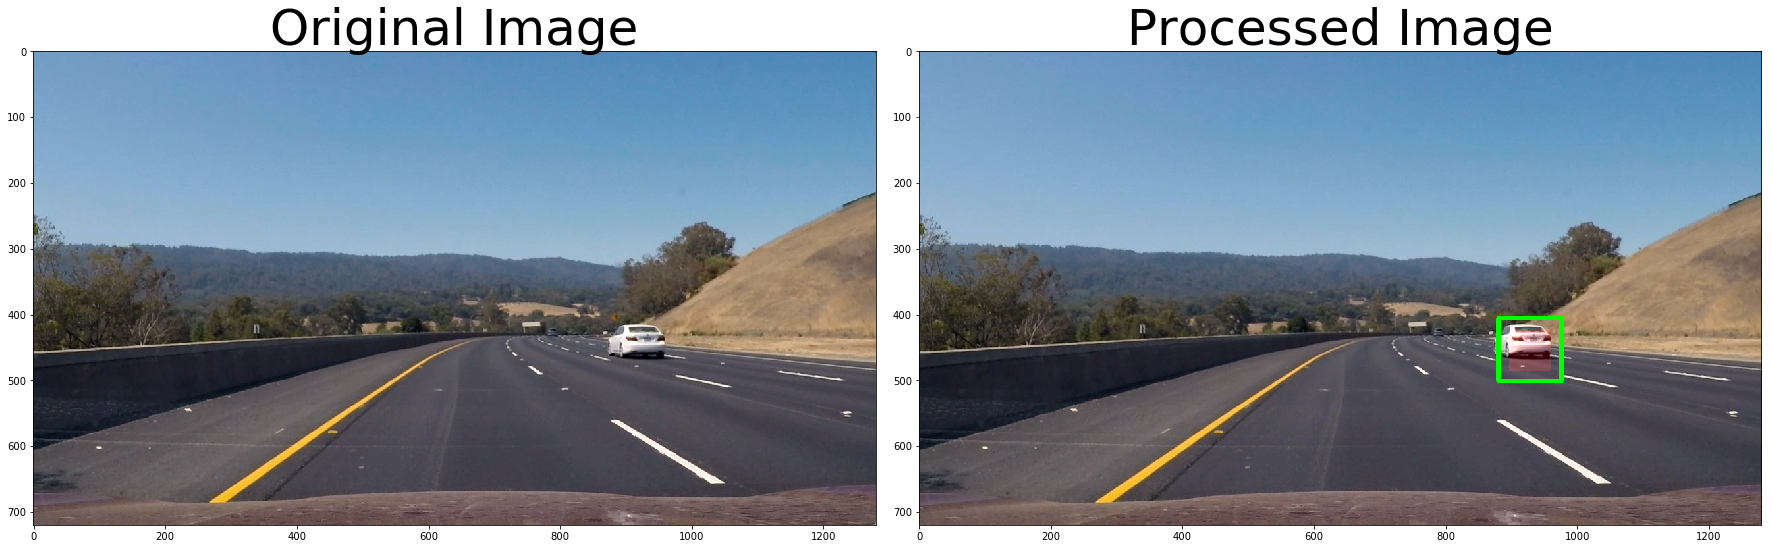

test5.jpg


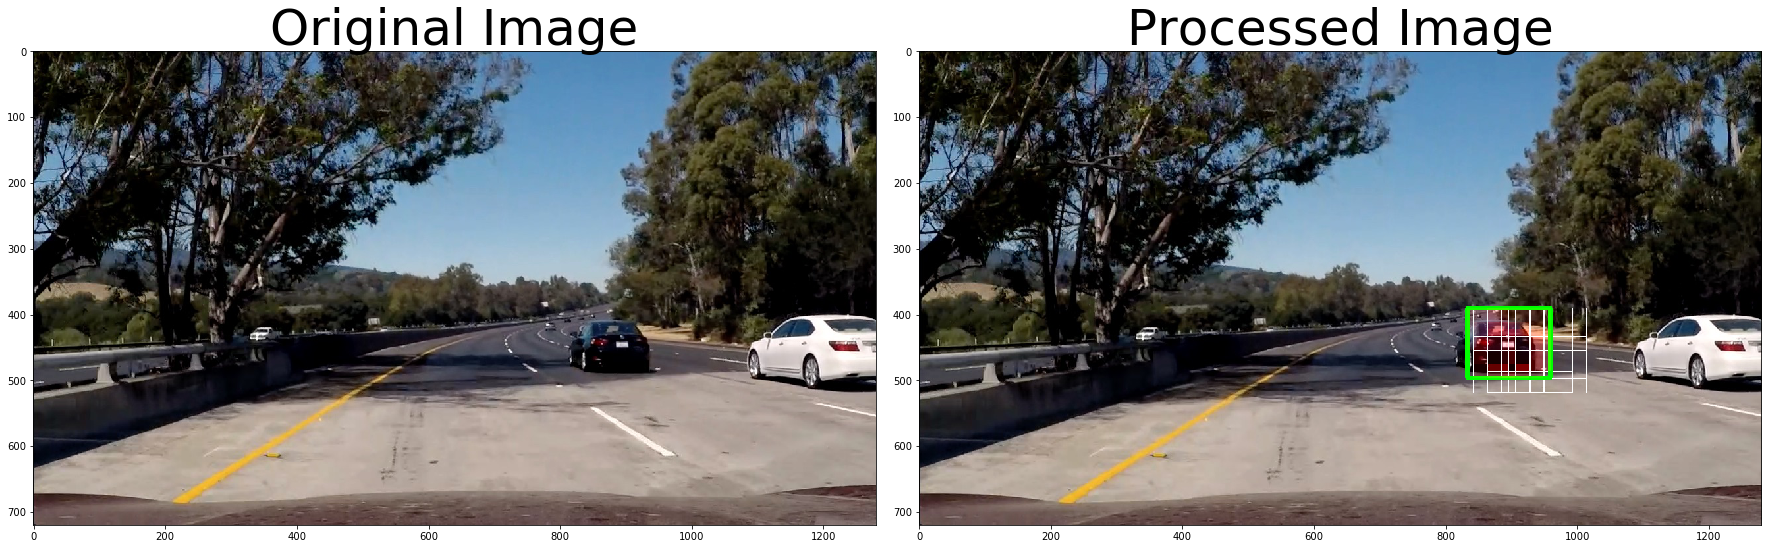

test6.jpg


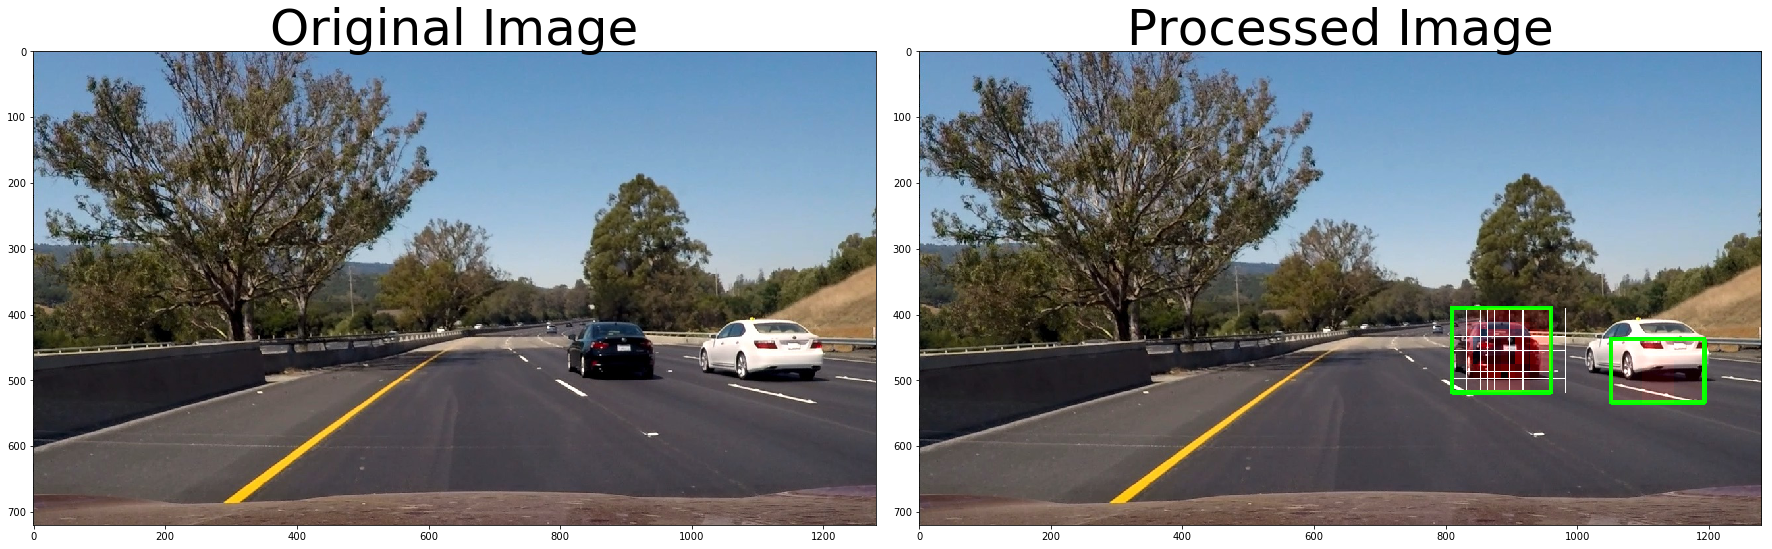

test1.jpg


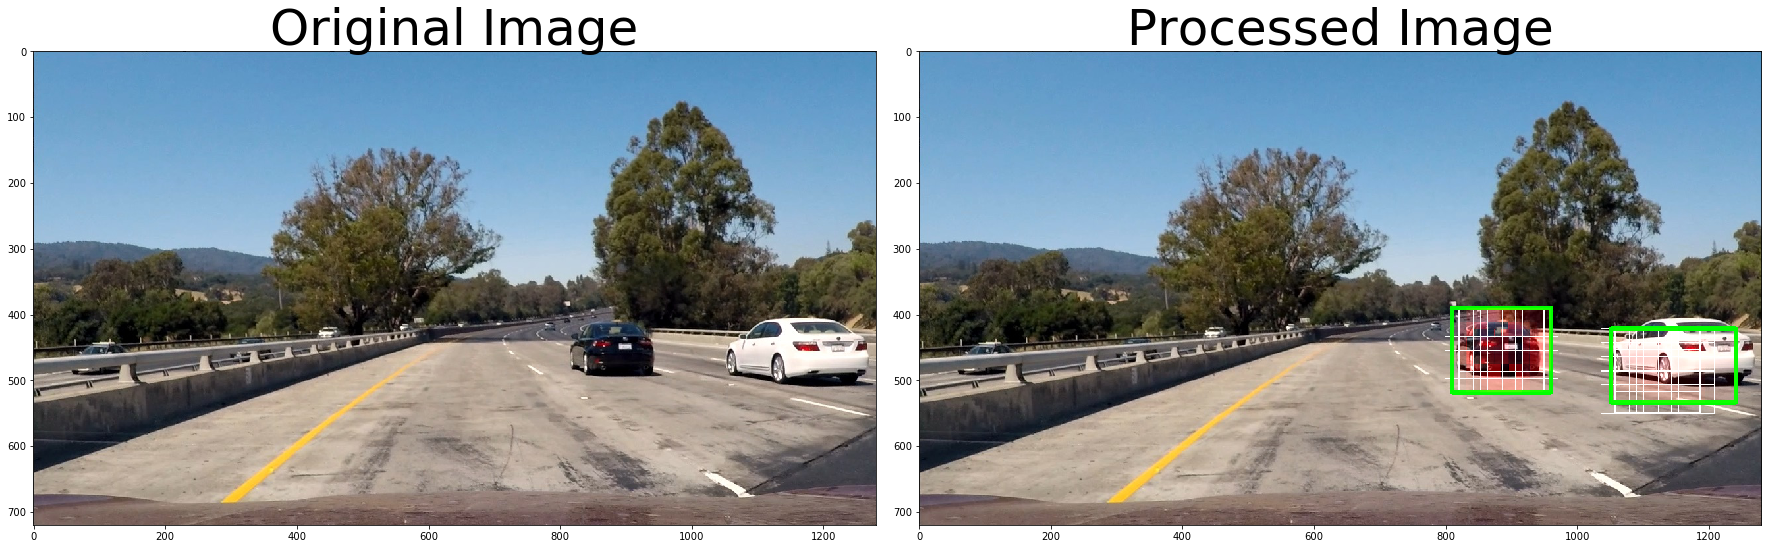

test4.jpg


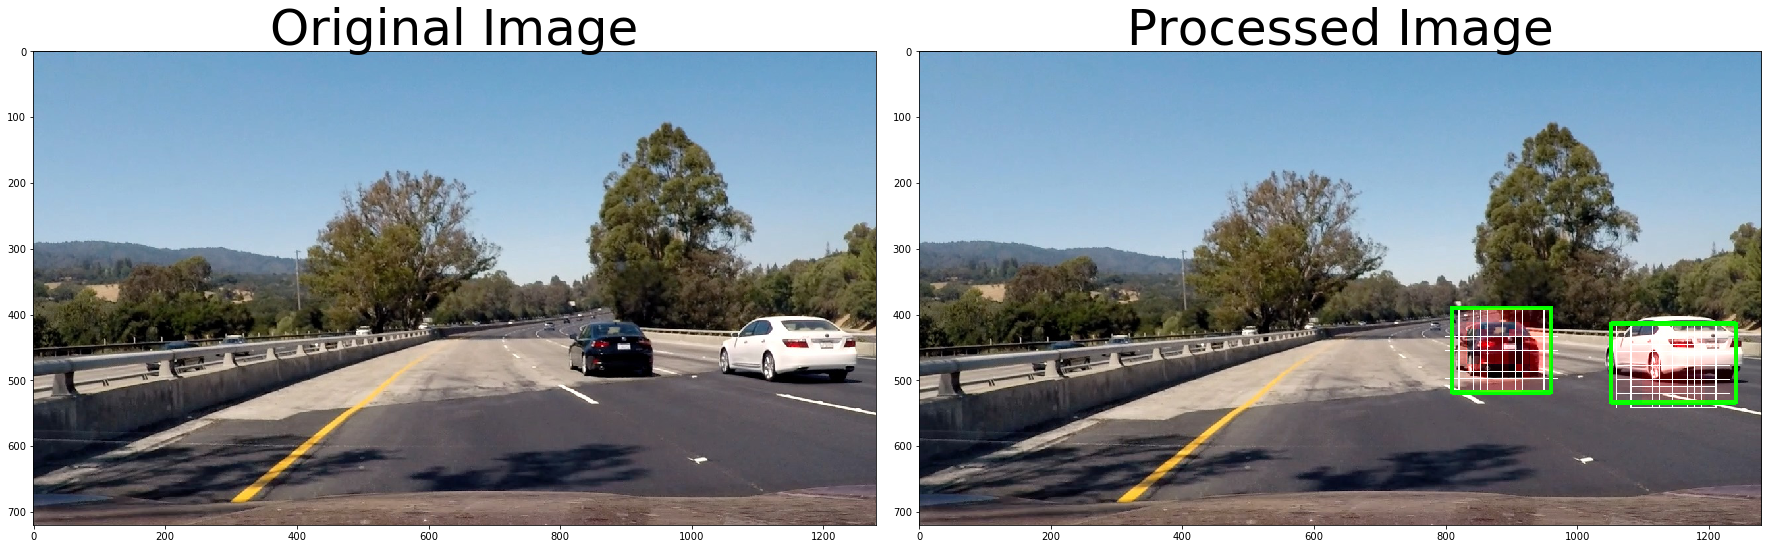

test2.jpg


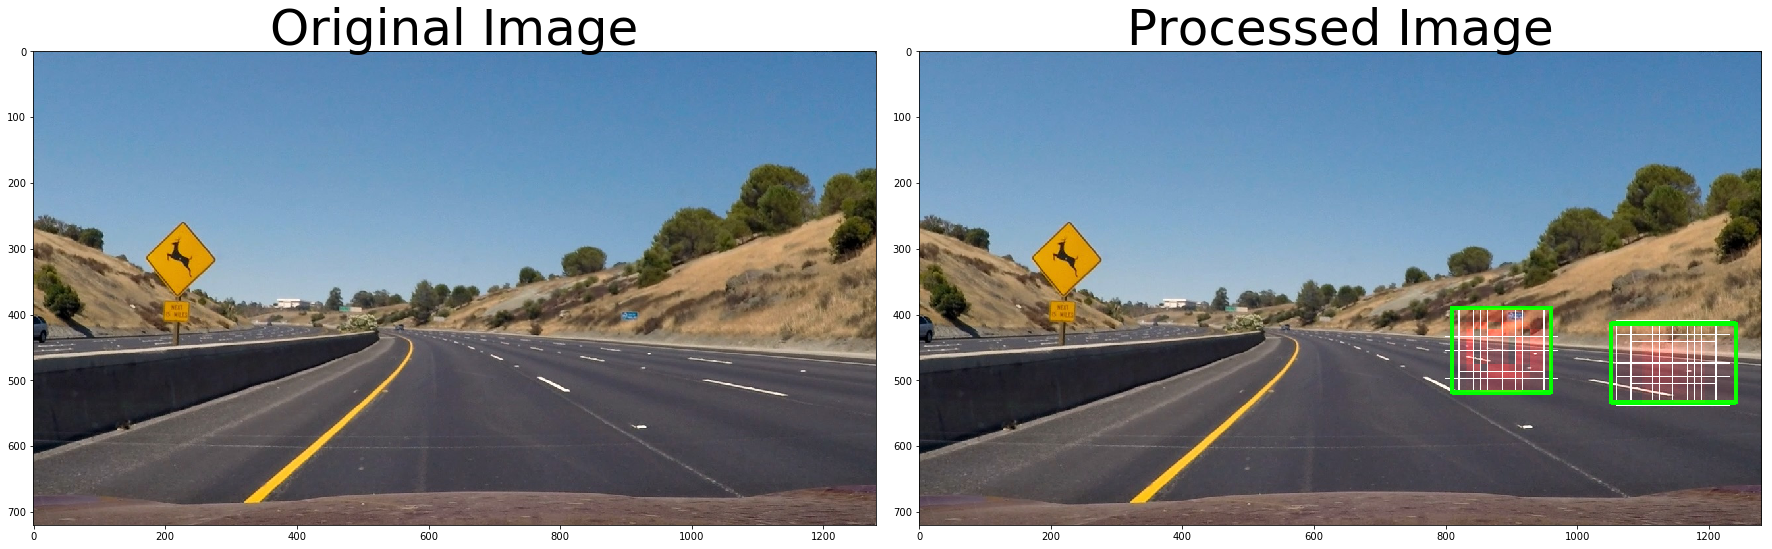

In [455]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import scipy.misc
import pickle

print(os.listdir("test_images/"))
from scipy.ndimage.measurements import label

SVC_PATH ="svc.p"

global image_counter,heatmap
image_counter=0
heatmap = Heatmap(0)

(color_space,hog_channel,spatial_feat,hist_feat,hog_feat) = ("RGB","ALL",True,False,True)#params[i]
cell_per_block=3

#the process chain 
def process_colored_image(image,smooth,debug,imageName,X_scaler,svc):
  global image_counter,heatmap
  image_counter += 1
  
  if image.shape[0]!= 720 or image.shape[1]!= 1280:
    image = cv2.resize(image,(1280, 720), interpolation = cv2.INTER_CUBIC)
    print("resize:",image.shape)

  normImage = image.copy().astype("float32") / 255.0
#  print("min:",np.min(normImage)," max:",np.max(normImage))

    
  windows = []
  result = image

  if smooth:
    search_param = ((64,390,486,224,1056,0.5),
     (96,390,534,38,278,0.5),
     (96,390,534,1002,1242,0.5),
     (160,444,658,10,278,0.66),
     (160,444,658,1002,1270,0.66),
     (192,430,622,10,332,0.66),
     (192,430,622,948,1270,0.66))
     
    windows += heatmap.getSearchAreas(normImage)
    result = drawBoxes(result, windows, color=(255,255,255), thick=(1))  
  else:
#    search_param = ((64,390,486,224,1056,0.5),
#      (96,390,534,160,1120,0.5),
#      (128,390,582,128,1152,0.5),
#      (160,390,658,19,1266,0.66))
#      (192,390,647,22,1258,0.66))
    search_param = ((64,390,671,10,1270,0.66),
      (96,390,551,21,1260,0.66),
      (128,390,605,10,1270,0.66),
      (160,390,658,19,1266,0.66))
#      (192,390,647,22,1258,0.66))
    
  if not smooth:
    heatmap = Heatmap(3)
    
  all_hot_windows = []
  for i in range(len(search_param)):  
    (size,y_start, y_stop, x_start, x_stop,ov) = search_param[i]

    new_win = slide_window(normImage, x_start_stop=(x_start, x_stop), y_start_stop=(y_start, y_stop), 
                    xy_window=(size,size), xy_overlap=(ov, ov))
    
###    
#    result = image
#    hot_windows = searchWindows(normImage, new_win, svc, X_scaler, color_space=color_space, 
#                      spatial_size=spatial_size, hist_bins=hist_bins, 
#                      orient=orient, pix_per_cell=pix_per_cell, 
#                      cell_per_block=cell_per_block, 
#                      hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                      hist_feat=hist_feat, hog_feat=hog_feat,hardNegative=False)                       
#    heatmap.update((image.shape[0],image.shape[1]),hot_windows)
#    result = drawBoxes(result, new_win, color=(255-(255*i/5), 255*i/5, 0), thick=2)  
#    result = heatmap.drawLabeledBoxes(result,(255,0,0))
#    plt.imshow(result)
#    plt.show()
####    
    
    
    windows += new_win
#  print(windows2)
    
  hot_windows = searchWindows(normImage, windows, svc, X_scaler, color_space=color_space, 
                      spatial_size=spatial_size, hist_bins=hist_bins, 
                      orient=orient, pix_per_cell=pix_per_cell, 
                      cell_per_block=cell_per_block, 
                      hog_channel=hog_channel, spatial_feat=spatial_feat, 
                      hist_feat=hist_feat, hog_feat=hog_feat,hardNegative=False)                       

#  result = drawBoxes(result, windows, color=(0,255,255), thick=(1))  
#  result = drawBoxes(result, hot_windows, color=(0, 0, 255), thick=2)                    
    
  heatmap.update((image.shape[0],image.shape[1]),hot_windows)
    
  if smooth:
    heatmap.average()
    result = heatmap.drawLabeledBoxes(result,(0,255,0),True)
  else:
    result = heatmap.drawLabeledBoxes(result,(255,0,0),False)
    

  if debug:
    if not imageName is None:
      path_to_image = os.path.join("output_images","{0}_{1}.jpg".format(imageName,"result"))
      scipy.misc.imsave(path_to_image, result)    
    
  return result


#loop over the test pictures
resultPath = "result_images/"
if not os.path.exists(resultPath):
  os.mkdir(resultPath)

data = {}
#load trained svc
with open(SVC_PATH, "rb") as f:
  data = pickle.load(f)

X_scaler = data["X_scaler"]
svc = data["svc"]


if True:
  item = "test3.jpg"
for item in os.listdir("test_images/"):
  #Read in and grayscale the image
  print(item)
  path_to_image = os.path.join("test_images",item)
  image = mpimg.imread(path_to_image)    

  result = process_colored_image(image,True,True,item[:-4],X_scaler, svc)

  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
  f.tight_layout()
  ax1.imshow(image)
  ax1.set_title('Original Image', fontsize=50)

  ax2.set_title('Processed Image', fontsize=50)
  ax2.imshow(result)
  plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
  #loop over the test pictures

  path_to_result = os.path.join(resultPath,"result_{0}".format(item))
  fig = plt.gcf()
  fig.savefig(path_to_result) 
  plt.show()


In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2
import numpy as np

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    return process_colored_image(image,True,True,None,X_scaler,svc)

In [456]:
global image_counter,leftLine,rightLine
image_counter=0
heatmap = Heatmap(2)
data = {}
#load trained svc
with open(SVC_PATH, "rb") as f:
  data = pickle.load(f)

X_scaler = data["X_scaler"]
svc = data["svc"]


white_output = 'project_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


100%|█████████▉| 1260/1261 [12:20<00:00,  1.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result.mp4 

CPU times: user 47min 11s, sys: 20.1 s, total: 47min 31s
Wall time: 12min 21s
